In [238]:
import rdkit
import random
import time
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from random import randint
import matplotlib.pyplot as plt
from rdkit.Chem.Scaffolds import MurckoScaffold
import math
from itertools import combinations

In [239]:
def get_mol(smiles):
    return Chem.MolFromSmiles(smiles)

In [240]:
def get_smiles(mol):
    return Chem.MolToSmiles(mol)

In [268]:
def get_mol_clone(mol):
    return get_mol(get_smiles(mol))

In [241]:
def molecule_from_smiles_img(smi):
    return Draw.MolToImage(get_mol(smi))

In [242]:
def get_scaffold(mol):
    return MurckoScaffold.GetScaffoldForMol(mol)

In [285]:
def plot_molecules(mol_str_1, mol_str_2):
    fig, axs = plt.subplots(
        1, 2, figsize=(10, 5)
    )  # Create a subplot with 1 row and 2 columns

    # Draw the input molecule
    axs[0].imshow(molecule_from_smiles_img(mol_str_1))
    axs[0].set_title("Input")
    axs[0].axis("off")  # Hide axes

    # Draw the output molecule
    axs[1].imshow(molecule_from_smiles_img(mol_str_2))
    axs[1].set_title("Output")
    axs[1].axis("off")  # Hide axes

    return plt.show()

In [244]:
def get_idxs_of_carbon_for_new_bond(mol):
  """Return indices of all carbon atoms available for new bond.

  Technically, it returns the indices of Carbon atoms that have
  at least one bond with hydrogen atom.
  """

  carbon_indices = []

  for atom in mol.GetAtoms():
    if atom.GetAtomicNum() == 6:
      bonds = atom.GetBonds()
      num_bonds = sum([b.GetBondTypeAsDouble() for b in bonds])
      if num_bonds < 4:
        carbon_indices.append(atom.GetIdx())

  return carbon_indices

In [272]:
def get_scaffold_and_attachment_points(mol):
    scaffold = get_mol_clone(get_scaffold(mol))
    
    if Chem.MolToSmiles(scaffold) != "":
        # If we have a valid scaffold then we are using it.
        scaffold = get_mol_clone(mol)
        
    return (scaffold, get_idxs_of_carbon_for_new_bond(scaffold))

In [304]:
def get_mol_after_adding_attachment_points_at(mol, at):
    connecting_atom = Chem.Atom("*")
    mutable_copy = Chem.RWMol(get_mol_clone(mol))
    
    for attachment_idx in at:
        connection_idx = mutable_copy.AddAtom(connecting_atom)
        mutable_copy.AddBond(attachment_idx, connection_idx, Chem.BondType.SINGLE)

    
    mol = mutable_copy.GetMol()
    AllChem.Compute2DCoords(mol)
    
    return mol

In [279]:
def attach_numbers_to_attachment_points(mol):
    mol_str = get_smiles(mol)
    smiles = ""
    count = 1
    for char in mol_str:
        if char == "*":
          smiles += f"[*:{count}]"
          count += 1
        else:
          smiles += char

    return get_mol(smiles)

In [248]:
def add_connection_point(mol, total_connection=1):
    """Return a smile after adding connecting point(s)."""
    scaffold = get_scaffold(mol)
    
    if Chem.MolToSmiles(scaffold) != "":
        # If we have a valid scaffold then we are using it.
        mol = scaffold
    
    connecting_atom = Chem.Atom("*")
    mutable_copy = Chem.RWMol(mol)
    
    carbon_indices = get_idxs_of_carbon_for_new_bond(mol)
    total_available_carbon = len(carbon_indices)
    
    loop_range = total_available_carbon if total_available_carbon < total_connection else total_connection
    
    random.seed(time.time())
    for idx in range(loop_range):
        attachment_idx = carbon_indices[randint(0, len(carbon_indices) - 1)]
        connection_idx = mutable_copy.AddAtom(connecting_atom)
    
        mutable_copy.AddBond(attachment_idx, connection_idx, Chem.BondType.SINGLE)
    
        for idx in range(len(carbon_indices)):
            if carbon_indices[idx] == attachment_idx:
              carbon_indices.pop(idx)
              break
    
    mol = mutable_copy.GetMol()
    AllChem.Compute2DCoords(mol)
    
    return get_smiles(mol)

In [249]:
molecules = [
  "c1ccccc1",
  "CC(C)(C)C1=CC(O)=CC=C1O",
  "CC(C)(C)c1nc(c(s1)-c1ccnc(N)n1)-c1cccc(NS(=O)(=O)c2c(F)cccc2F)c1F",
  "CO",
  "OC=O",
  "CCOCC",
  "COC1=CC23CCCN2CCC4=CC5=C(C=C4C3C1O)OCO5", # Cephalotaxin
  "CC1(OC2C(OC(C2O1)(C#N)C3=CC=C4N3N=CN=C4N)CO)C", # Remdesivir
  "CC(=O)OC1=CC=CC=C1C(=O)O", # Aspirin
  "CC(CN1C=NC2=C(N=CN=C21)N)OCP(=O)(O)O", #Tenofovir
  "C1=CN=CC=C1C(=O)NN", # Isoniazid
  "CC1C2C(CC3(C=CC(=O)C(=C3C2OC1=O)C)C)O", # Artemisin
  "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O", #Ibuprofen
]


In [250]:
modified_molecules = [add_connection_point(get_mol(mol), 100) for mol in molecules]

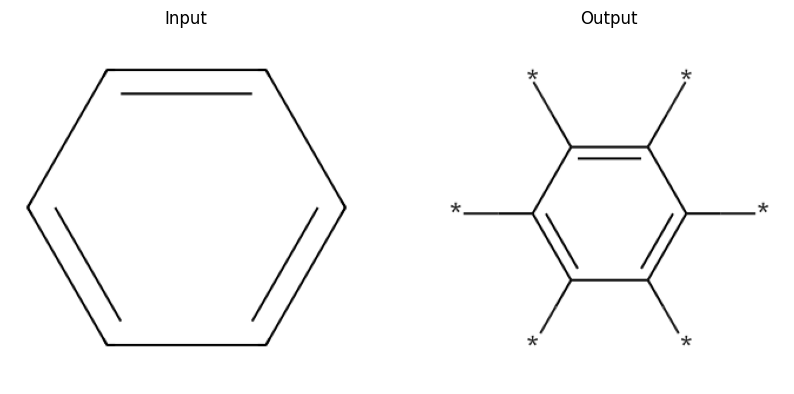

Input: c1ccccc1 -> *c1c(*)c(*)c(*)c(*)c1*


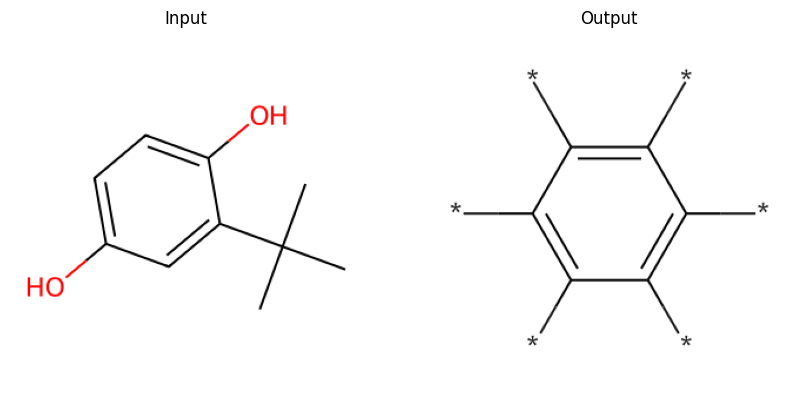

Input: CC(C)(C)C1=CC(O)=CC=C1O -> *c1c(*)c(*)c(*)c(*)c1*


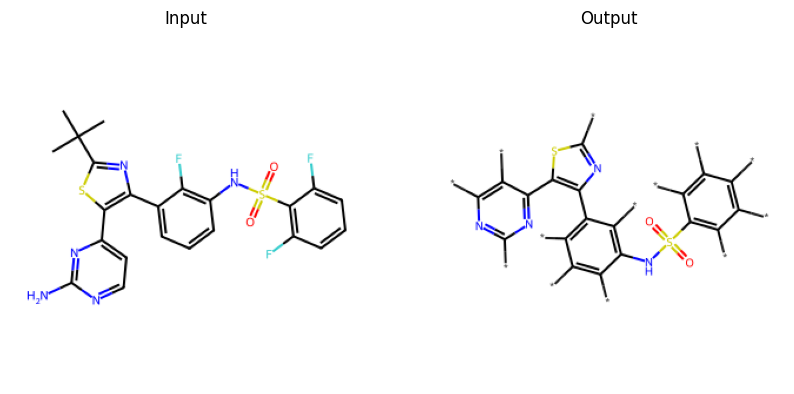

Input: CC(C)(C)c1nc(c(s1)-c1ccnc(N)n1)-c1cccc(NS(=O)(=O)c2c(F)cccc2F)c1F -> *c1nc(*)c(*)c(-c2sc(*)nc2-c2c(*)c(*)c(*)c(NS(=O)(=O)c3c(*)c(*)c(*)c(*)c3*)c2*)n1


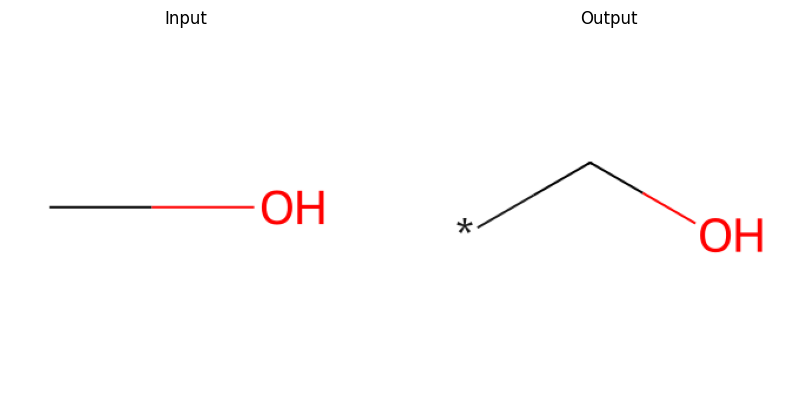

Input: CO -> *CO


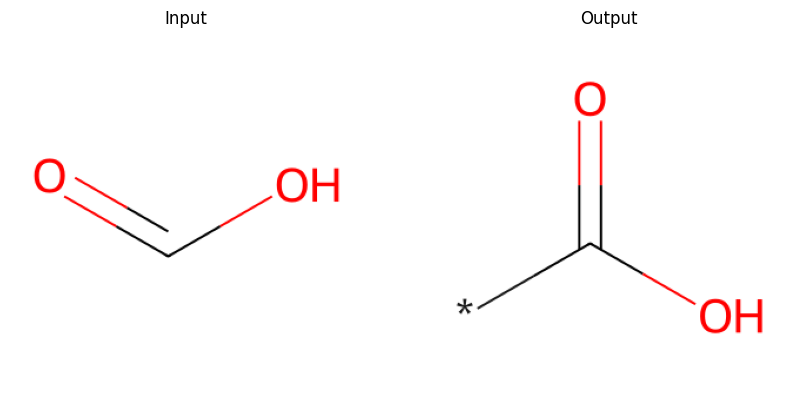

Input: OC=O -> *C(=O)O


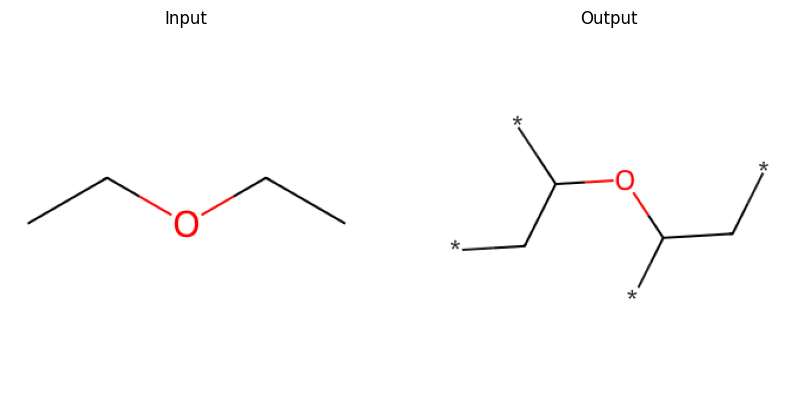

Input: CCOCC -> *CC(*)OC(*)C*


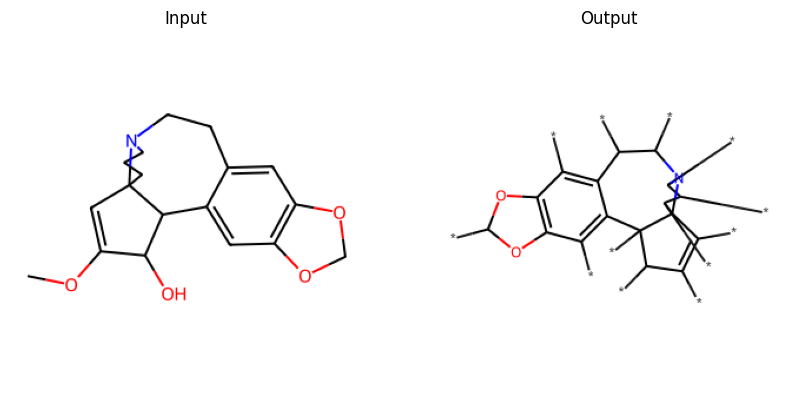

Input: COC1=CC23CCCN2CCC4=CC5=C(C=C4C3C1O)OCO5 -> *C1=C(*)C23C(*)C(*)C(*)N2C(*)C(*)c2c(*)c4c(c(*)c2C3(*)C1*)OC(*)O4


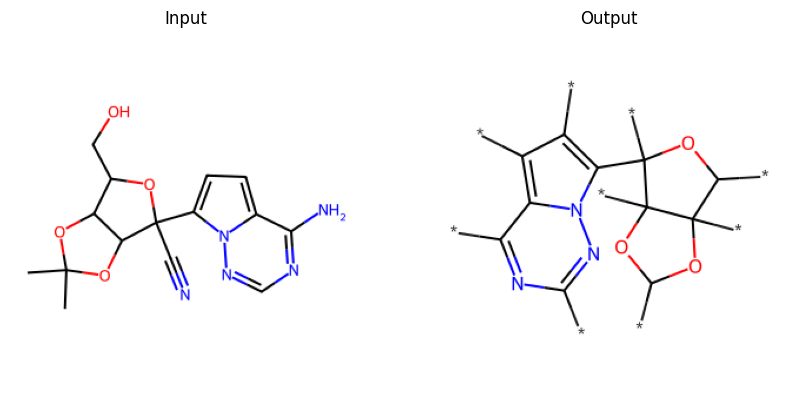

Input: CC1(OC2C(OC(C2O1)(C#N)C3=CC=C4N3N=CN=C4N)CO)C -> *c1nc(*)c2c(*)c(*)c(C3(*)OC(*)C4(*)OC(*)OC34*)n2n1


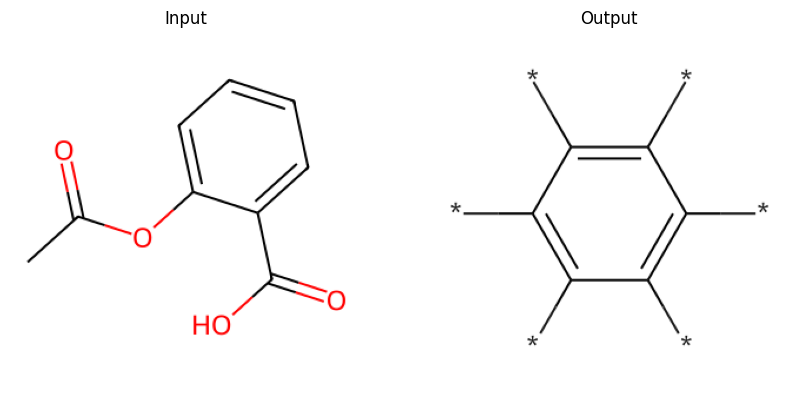

Input: CC(=O)OC1=CC=CC=C1C(=O)O -> *c1c(*)c(*)c(*)c(*)c1*


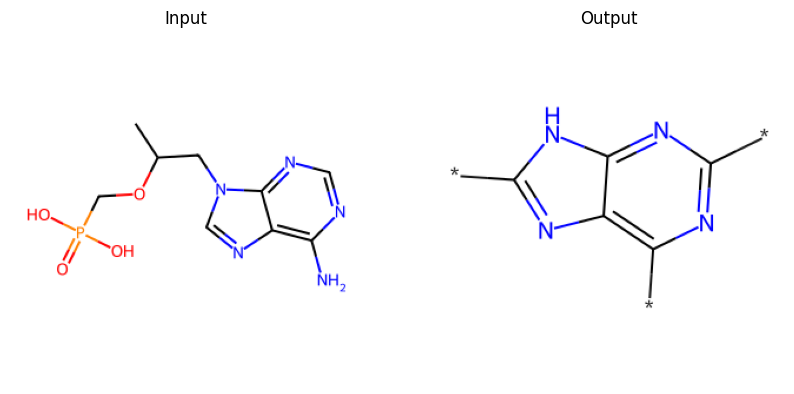

Input: CC(CN1C=NC2=C(N=CN=C21)N)OCP(=O)(O)O -> *c1nc(*)c2nc(*)[nH]c2n1


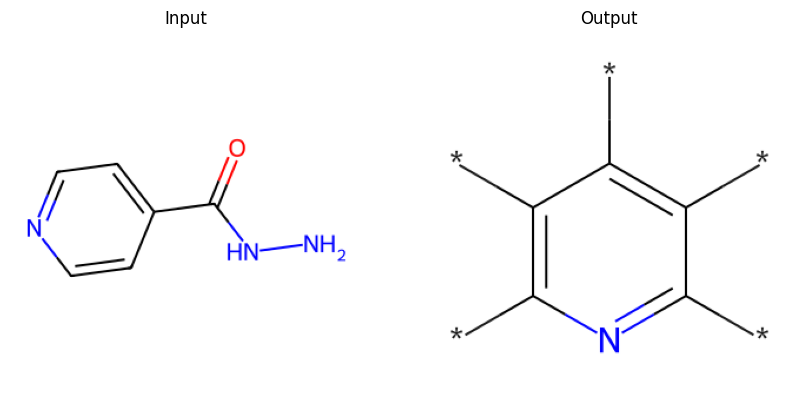

Input: C1=CN=CC=C1C(=O)NN -> *c1nc(*)c(*)c(*)c1*


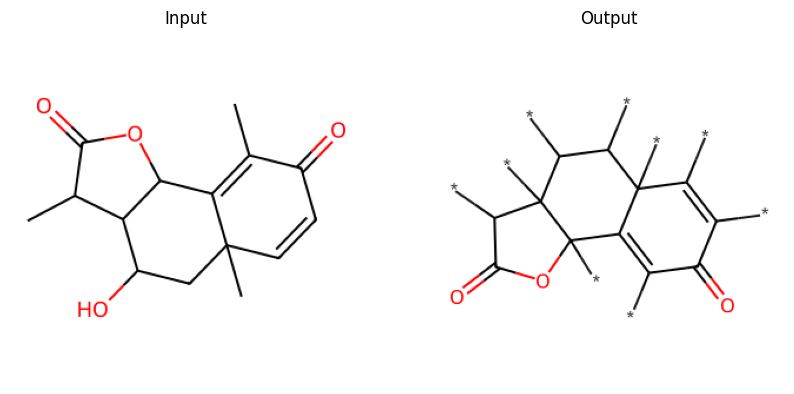

Input: CC1C2C(CC3(C=CC(=O)C(=C3C2OC1=O)C)C)O -> *C1=C(*)C2(*)C(=C(*)C1=O)C1(*)OC(=O)C(*)C1(*)C(*)C2*


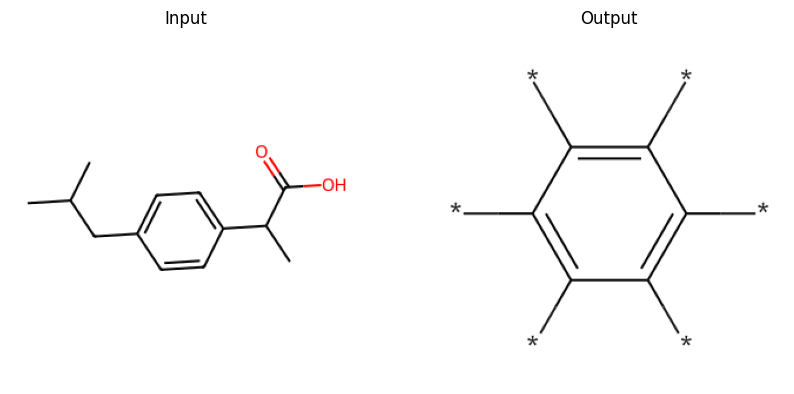

Input: CC(C)CC1=CC=C(C=C1)C(C)C(=O)O -> *c1c(*)c(*)c(*)c(*)c1*


In [251]:
%matplotlib inline

for input_smile, output_smile in zip(molecules, modified_molecules):
  plot_molecules(input_smile, output_smile)
  print(f"Input: {input_smile} -> {output_smile}")

In [46]:
def get_target_num_mols_for_given_mol(attachment_points_using, total_combinations):
    target = 1000
    target_for_current_mol = target // total_combinations

    muliplier = 1.5
    if attachment_points_using == 2:
        muliplier = 3    
    if attachment_points_using == 3:
        muliplier = 6
    
    return math.ceil(target_for_current_mol * muliplier)
    

In [47]:
def get_total_combination_of_mutation(attachment_points):
    # At index 0 we have total combinations taking one attachment point at a time.
    # At index 1 we have total combinations taking two attachment points at a time.
    # At index 2 we have total combinations taking three attachment points at a time.
    total_combination = [attachment_points, 0, 0]

    if attachment_points > 1:
        total_combination[1] = math.comb(attachment_points, 2)

    if attachment_points > 2:
        total_combination[2] = math.comb(attachment_points, 3)
        
    return sum(total_combination)


### The Algorigthm

1. First find all the attachment points.
2. We know the number of target molecules we want to generate. Also, we know the difference between expected and actual number of generated molecules. We need to adjust the target input little bit.
3. Calculate the total number of molecules we can generate using a combination of taking 1, 2, and 3 attachment points at a time.


mol, at = get_scaffold_and_attachment_points(get_mol("CC(C)(C)c1nc(c(s1)-c1ccnc(N)n1)-c1cccc(NS(=O)(=O)c2c(F)cccc2F)c1F"))
mol = get_mol_after_adding_attachment_points_at(mol, at[4:6])
Draw.MolToImage(attach_numbers_to_attachment_points(mol))

In [313]:
def get_all_comb_of_mol_with_attachment_points(smiles):
    mol = get_mol(smiles)
    scaffold, at = get_scaffold_and_attachment_points(mol)
    
    combs = [combinations(at, 1), combinations(at, 2), combinations(at, 3)]
    
    molecules = []
    
    for comb in combs:
        for current_at in comb:
            s = get_mol_clone(scaffold)
            m = get_mol_after_adding_attachment_points_at(s, current_at)
            m = attach_numbers_to_attachment_points(m)
            molecules.append(m)

    return molecules

In [314]:
c = get_all_comb_of_mol_with_attachment_points("CC(C)(C)c1nc(c(s1)-c1ccnc(N)n1)-c1cccc(NS(=O)(=O)c2c(F)cccc2F)c1F")

print(len(c))
# for m in c[0:10]:
#     print(get_smiles(m))
    # plot_molecules("CO", get_smiles(m))

231


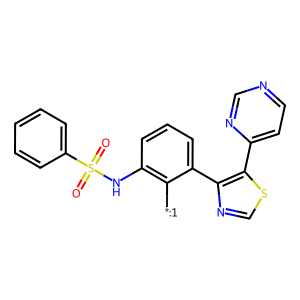

In [202]:
mol, at = get_scaffold_and_attachment_points(get_mol("CC(C)(C)c1nc(c(s1)-c1ccnc(N)n1)-c1cccc(NS(=O)(=O)c2c(F)cccc2F)c1F"))
mol = get_mol_after_adding_attachment_points_at(mol, [26])
Draw.MolToImage(attach_numbers_to_attachment_points(mol))

True